Во втором блокноте подключаемся к той же базе данных и выполняем SQL-запросы для агрегирования данных. Например, вычисляем суммарную выручку по событиям, анализируем популярность жанров артистов (на основании количества билетов или событий), распределение типов билетов и другие метрики. Затем строим как минимум три графика: 

1. Линейный график продаж во времени.
2. Гистограмму распределения цен билетов.
3. Круговую диаграмму по типам билетов.

In [32]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import config as cfg
import numpy as np

In [33]:
conn = psycopg2.connect(
        dbname=cfg.DB_NAME,
        user=cfg.USER_NAME,
        password=cfg.PASSWORD,
        host=cfg.HOST,
        port=cfg.PORT
)
cursor = conn.cursor()

In [34]:

# 1) Выручка по событиям
query1 = """
SELECT e.event_name AS event_name, SUM(t.price) AS revenue
FROM proj.events e
JOIN proj.tickets t ON e.event_id = t.event_id
GROUP BY e.event_name
ORDER BY revenue DESC;
"""
df_revenue = pd.read_sql(query1, conn)

# 2) Популярность жанров (по числу проданных билетов на события артистов данного жанра)
query2 = """
SELECT a.main_genre AS genre, COUNT(*) AS tickets_sold
FROM proj.artists a
JOIN proj.events e ON a.artist_id = e.artist_id
JOIN proj.tickets t ON e.event_id = t.event_id
GROUP BY a.main_genre;
"""
df_genres = pd.read_sql(query2, conn)

# 3) Распределение типов билетов
query3 = "SELECT ticket_type, COUNT(*) AS count FROM proj.tickets GROUP BY ticket_type;"
df_types = pd.read_sql(query3, conn)

# 4) Временной ряд продаж (сумма по датам покупки)
query4 = "SELECT purchase_date, price, ticket_type FROM proj.tickets;"
df_tickets = pd.read_sql(query4, conn)
df_tickets['date'] = pd.to_datetime(df_tickets['purchase_date']).dt.date
sales_by_date = df_tickets.groupby('date')['price'].sum().reset_index()



C:\Users\egort\AppData\Local\Temp\ipykernel_912\1442690306.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_revenue = pd.read_sql(query1, conn)
C:\Users\egort\AppData\Local\Temp\ipykernel_912\1442690306.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_genres = pd.read_sql(query2, conn)
C:\Users\egort\AppData\Local\Temp\ipykernel_912\1442690306.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_types = pd.read_sql(query3, conn)
C:\Users\egort\AppData\Local\Temp\ipykernel_912\1442690306.py:27: UserWarning: p

Линейный график продаж по времени: строим график по `sales_by_date`. Это позволит увидеть тенденции во времени (сезонность, рост/спады продаж). Линейный график предпочтителен для временных рядов, так как показывает изменения величин по оси времени.

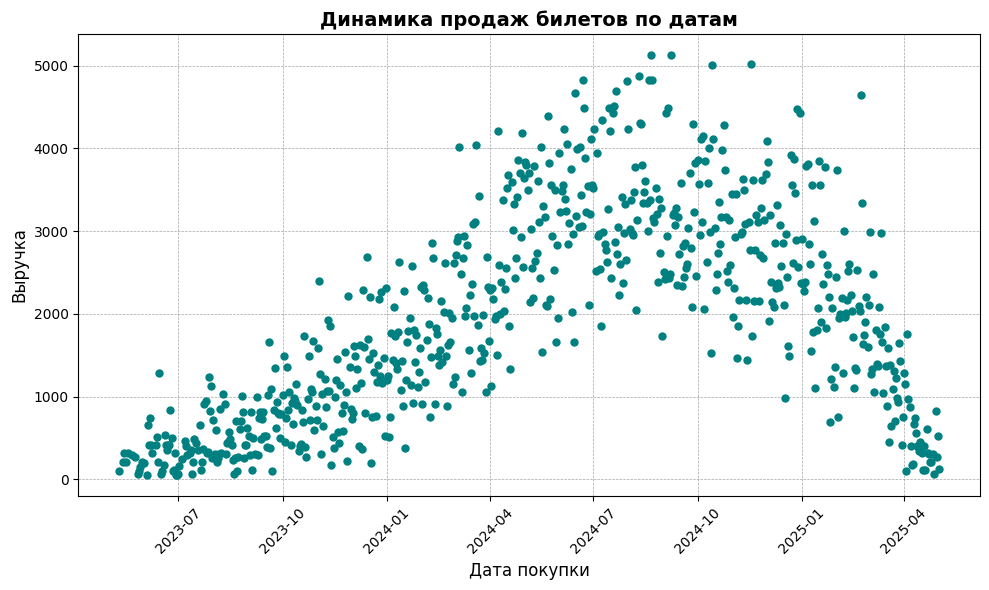

In [35]:
plt.figure(figsize=(10,6))
plt.plot(sales_by_date['date'], sales_by_date['price'], marker='o', linestyle='', color='teal', markersize=5)
plt.xlabel('Дата покупки', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.title('Динамика продаж билетов по датам', fontsize=14, fontweight='bold')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Гистограмма распределения цен билетов: строим гистограмму цен всех билетов (`price`). На ней видно, какая доля билетов продаётся по каждому ценовому диапазону. Например, пик в районе цены стандарт+ или premium иллюстрирует различия в ценах по типам.

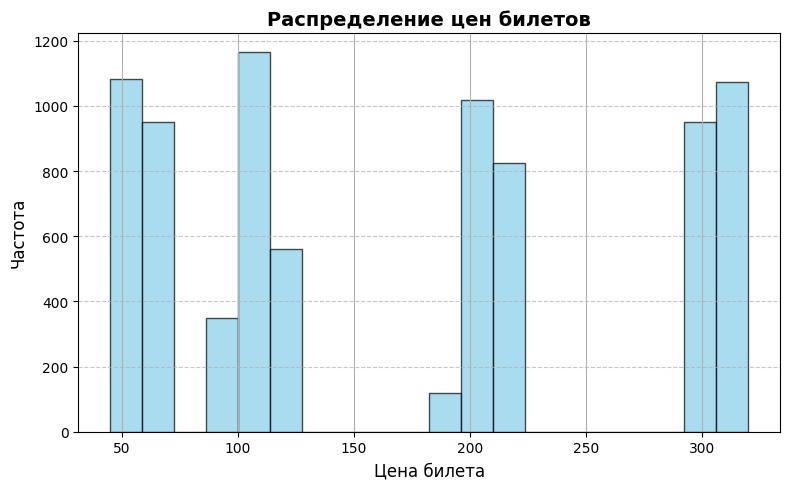

In [36]:
plt.figure(figsize=(8,5))
df_tickets['price'].hist(bins=20, edgecolor='black', color='skyblue', alpha=0.7)
plt.xlabel('Цена билета', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение цен билетов', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Гистограмма популярности жанров

Данный график отображает количество проданных билетов для каждого жанра. Это позволяет визуально оценить, какие жанры пользуются наибольшей популярностью среди аудитории. По оси X представлены жанры, а по оси Y — количество проданных билетов. Гистограмма помогает выявить лидеров и аутсайдеров по популярности жанров.

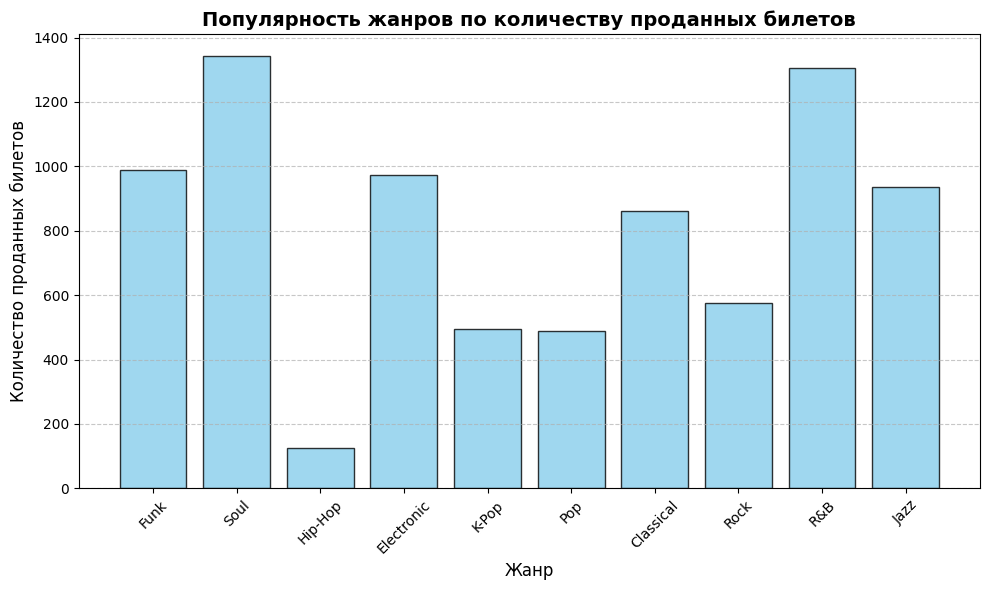

In [37]:
plt.figure(figsize=(10,6))
plt.bar(df_genres['genre'], df_genres['tickets_sold'], color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Жанр', fontsize=12)
plt.ylabel('Количество проданных билетов', fontsize=12)
plt.title('Популярность жанров по количеству проданных билетов', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Проверка гипотезы о средней цене билетов

Гипотеза: «Средняя цена билетов типа `premium` выше, чем `vip или standart`».

Для проверки гипотезы:
1. Извлечём цены билетов по типам `premium`, `vip` и `standart`.
2. Применим статистический тест для сравнения средних двух выборок.
3. Рассчитаем средние значения и p-value, чтобы сделать вывод о значимости различий.

In [38]:
prices_premium = df_tickets[df_tickets['ticket_type'] == 'premium']['price']
prices_economy_standard = df_tickets[df_tickets['ticket_type'].isin(['vip', 'standard'])]['price']
t_stat, p_val = stats.ttest_ind(prices_premium, prices_economy_standard, equal_var=False)
print(f"premium avg={prices_premium.mean():.2f}, economy+standard avg={prices_economy_standard.mean():.2f}, p-value={p_val:.4f}")


premium avg=207.50, economy+standard avg=206.27, p-value=0.4354


### Гипотеза: Зависимость между вместимостью площадки и количеством проданных билетов

Гипотеза: «Есть зависимость между вместимостью площадки и количеством проданных билетов».

Для проверки гипотезы:
1. Извлечём данные о вместимости площадок из таблицы `venues`.
2. Подсчитаем количество проданных билетов для каждого события из таблицы `tickets`.
3. Рассчитаем коэффициент корреляции между двумя числовыми признаками.

C:\Users\egort\AppData\Local\Temp\ipykernel_912\1271404586.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_capacity = pd.read_sql(query5, conn)


Correlation (capacity vs sold): r = 0.86


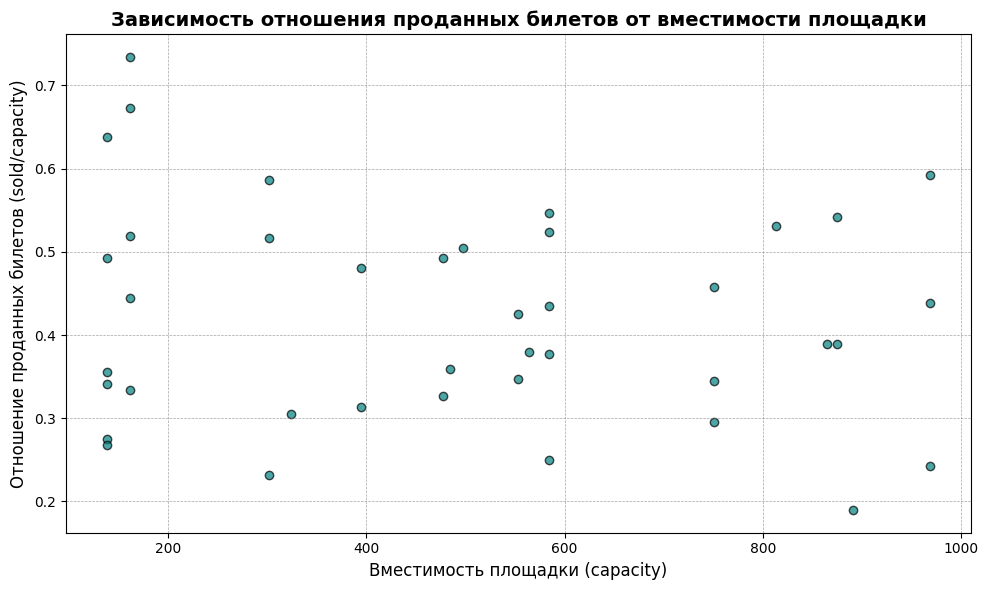

In [44]:
query5 = """
SELECT e.event_id, v.capacity, COUNT(t.*) AS sold
FROM proj.events e
JOIN proj.venues v ON e.venue_id = v.venue_id
LEFT JOIN proj.tickets t ON e.event_id = t.event_id
GROUP BY e.event_id, v.capacity;
"""
df_capacity = pd.read_sql(query5, conn)
corr, _ = stats.pearsonr(df_capacity['capacity'], df_capacity['sold'])
print(f"Correlation (capacity vs sold): r = {corr:.2f}")
# Добавляем столбец с отношением sold/capacity
df_capacity['sold_ratio'] = df_capacity['sold'] / df_capacity['capacity']

# Строим график зависимости sold_ratio от capacity
plt.figure(figsize=(10, 6))
plt.scatter(df_capacity['capacity'], df_capacity['sold_ratio'], alpha=0.7, color='teal', edgecolor='black')
plt.xlabel('Вместимость площадки (capacity)', fontsize=12)
plt.ylabel('Отношение проданных билетов (sold/capacity)', fontsize=12)
plt.title('Зависимость отношения проданных билетов от вместимости площадки', fontsize=14, fontweight='bold')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Гипотеза: Продажи по дням недели распределены неравномерно (χ²-тест)

Для проверки гипотезы:
1. Подсчитаем количество продаж по каждому дню недели (понедельник, вторник и т.д.).
2. Применим χ²-тест на равномерность распределения (тест согласия).
3. Сделаем вывод о равномерности распределения продаж.

Chi2=5.00, p-value=0.5439


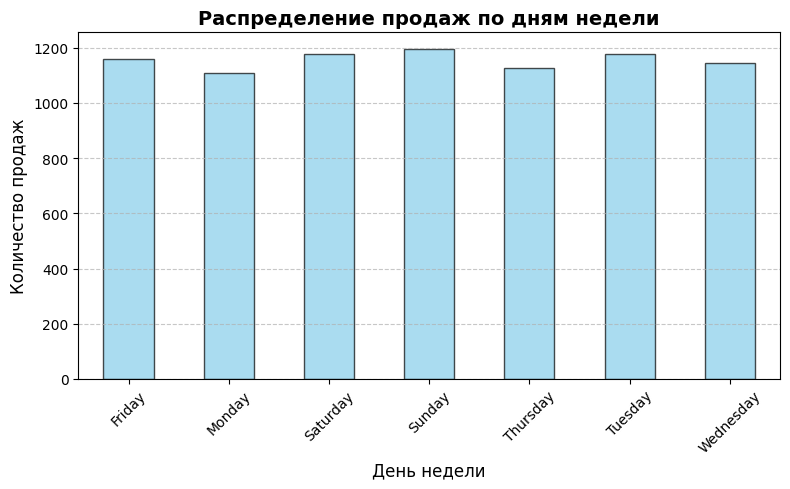

In [46]:
df_tickets['weekday'] = pd.to_datetime(df_tickets['purchase_date']).dt.day_name()
counts = df_tickets['weekday'].value_counts().sort_index()
chi2, p_chi = stats.chisquare(counts.values)
print(f"Chi2={chi2:.2f}, p-value={p_chi:.4f}")


plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.title('Распределение продаж по дням недели', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [47]:
cursor.close()
conn.close()